In [ ]:
!pip install -U datasets faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
from datasets import Dataset, load_dataset
from sentence_transformers import SentenceTransformer

# Load
dataset = load_dataset("Images")
model = SentenceTransformer('clip-ViT-B-32')

# Map (Ensure you are mapping the split, not the dict)
# It's safer to map the specific split directly
train_ds = dataset['train'].map(
    lambda example: {'embeddings': model.encode(example['image'])},
    batched=True,
    batch_size=32
)

# Explicitly initialize the index
try:
    train_ds.add_faiss_index(column='embeddings')
    print("Success!")
except AttributeError:
    print("Method still missing. Re-installing datasets...")
    # !pip install -U datasets faiss-gpu

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Success!


In [ ]:
# 1. Save the processed data (text, image paths, etc.)
#train_ds.save_to_disk("my_processed_dataset")

# 2. Save the FAISS index specifically
train_ds.save_faiss_index('embeddings', 'my_index.faiss')
train_ds.drop_index('embeddings')
train_ds.save_to_disk("my_processed_dataset")
train_ds.load_faiss_index('embeddings', 'my_index.faiss')

Saving the dataset (0/1 shards):   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
model.save('clip_model_local')

In [ ]:
prompt = model.encode("picture music notes")

In [ ]:
scores, retrieved_examples = train_ds.get_nearest_examples('embeddings', prompt,k=2)

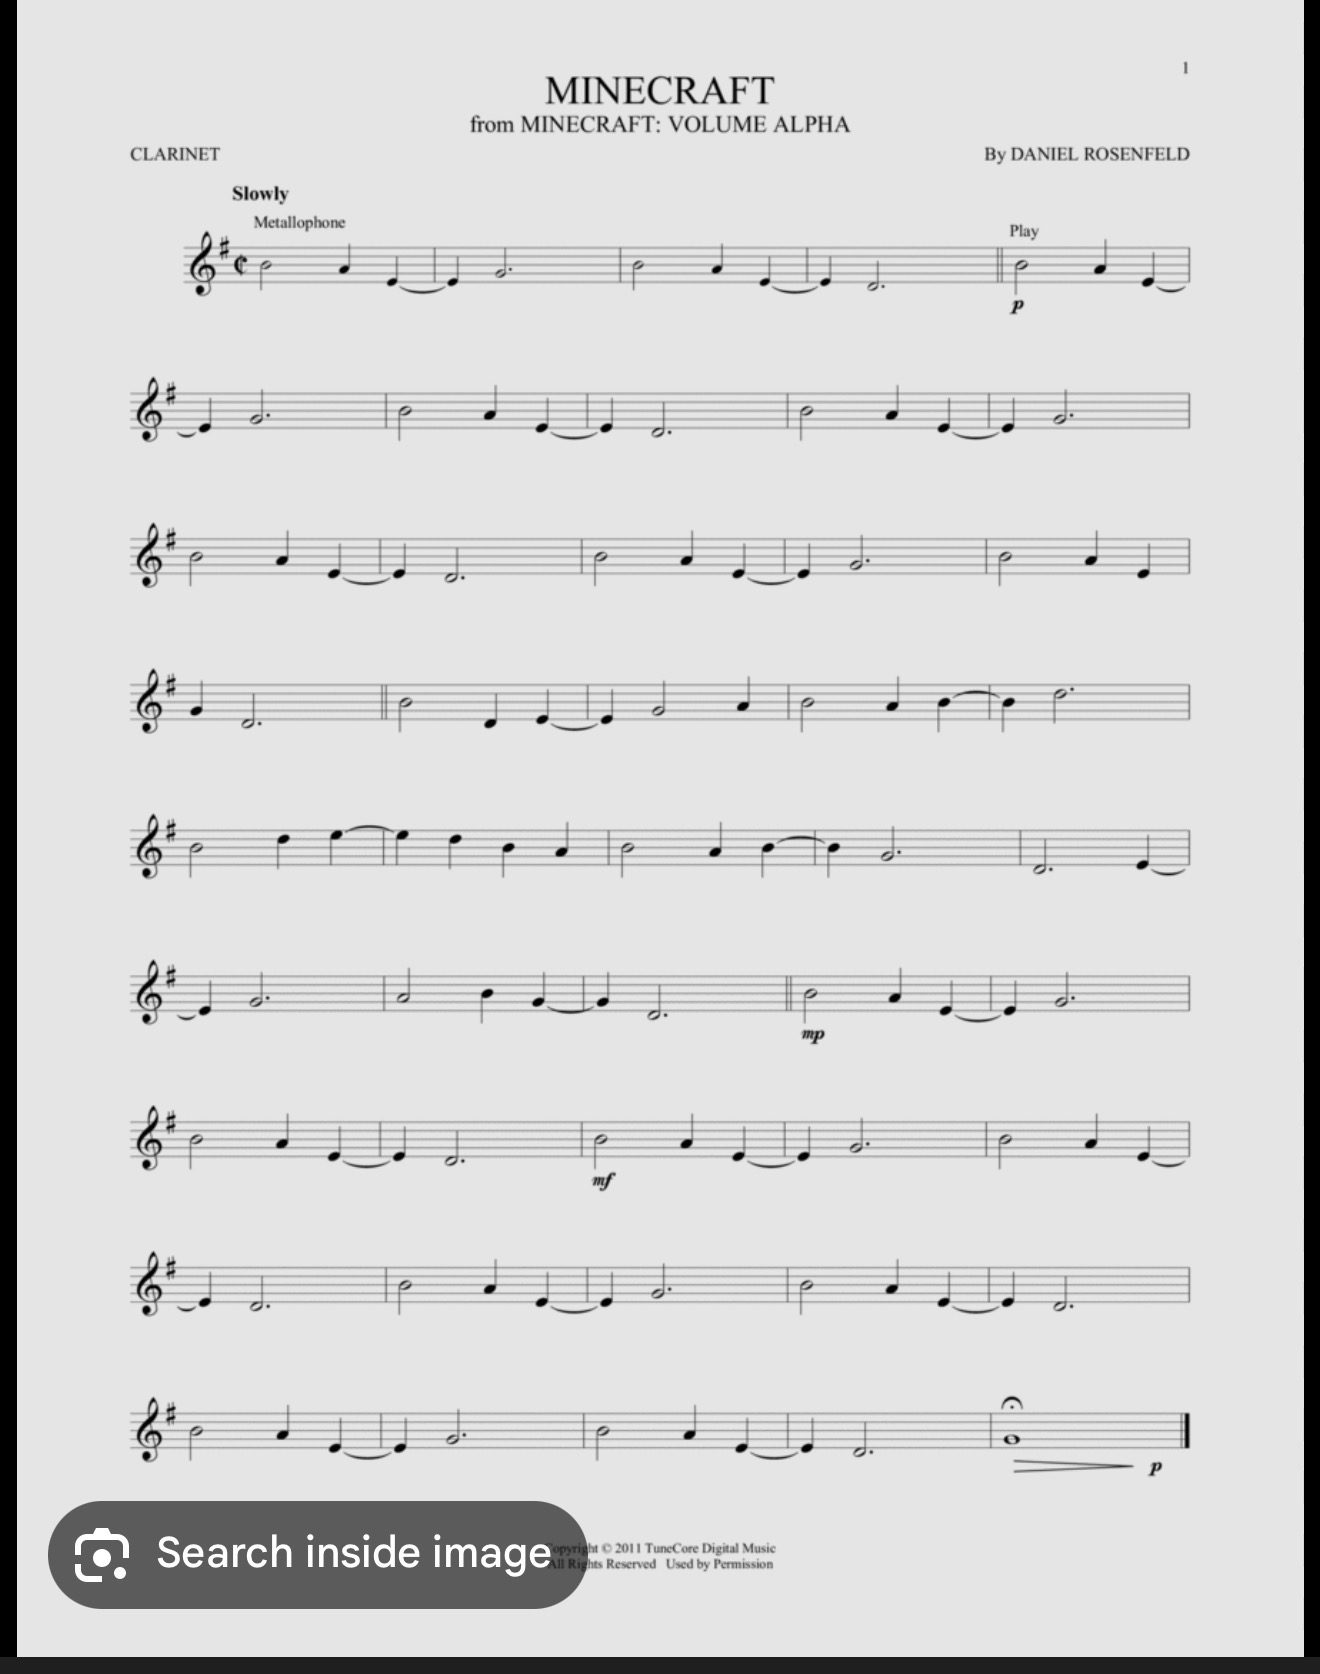

In [ ]:
retrieved_examples['image'][0]

In [ ]:
%%writefile frontend_files/app.py

import streamlit as st
import requests
from PIL import Image
from io import BytesIO
from datasets import load_from_disk
from sentence_transformers import SentenceTransformer

# Streamlit UI for Image search
st.title("Natural Language based Image search ")
st.write("User can search his image repository using Natural Language using prompt")

# Image URL
ImageURL = st.text_input("Image URL/Google Drive/Image S3")

SearchPrompt = st.text_input("Search Prompt")

if st.button("Search"):
  @st.cache_resource # Use this so it only loads ONCE when the app starts
  def load_data():
    # Load the table data
    ds = load_from_disk("my_processed_dataset")
    # Attach the pre-calculated index
    ds.load_faiss_index('embeddings', 'my_index.faiss')
    return ds

  dataset = load_data()
  model = SentenceTransformer('./clip_model_local')
  prompt = model.encode(SearchPrompt)
  scores, retrieved_examples = dataset.get_nearest_examples('embeddings', prompt,k=2)
  st.image(retrieved_examples['image'][0], caption="Image from Search")
  st.image(retrieved_examples['image'][1], caption="Image from Search")



Writing frontend_files/app.py


In [ ]:
%%writefile frontend_files/requirements.txt
streamlit==1.43.2
requests==2.32.3
datasets
pillow
sentence-transformers
faiss-cpu

Writing frontend_files/requirements.txt


In [ ]:
%%writefile frontend_files/Dockerfile
# Use a minimal base image with Python 3.9 installed
FROM python:3.9-slim

# Set the working directory inside the container to /app
WORKDIR /app

# Copy all files from the current directory on the host to the container's /app directory
COPY . .

# Install Python dependencies listed in requirements.txt
RUN pip3 install -r requirements.txt

# Define the command to run the Streamlit app on port 8501 and make it accessible externally
CMD ["streamlit", "run", "app.py", "--server.port=7860", "--server.address=0.0.0.0", "--server.enableXsrfProtection=false"]

Writing frontend_files/Dockerfile


In [ ]:
access_key = ""  # Your Hugging Face token created from access keys in write mode
from huggingface_hub import create_repo, upload_file, HfApi,login
repo_id = "kmrao99/MohanImageSearchFrontend"  # Your Hugging Face space id

In [ ]:
login()

In [ ]:
# Try to create the repository for the Hugging Face Space
print(repo_id)
try:
    create_repo("MohanImageSearchFrontend",
        repo_type="space",  # Specify the repository type as "space"
        space_sdk="docker",  # Specify the space SDK as "docker" to create a Docker space
        private=False  # Set to True if you want the space to be private
    )
except Exception as e:
    # Handle potential errors during repository creation
    if "RepositoryAlreadyExistsError" in str(e):
        print("Repository already exists. Skipping creation.")
    else:
        print(f"Error creating repository: {e}")

kmrao99/MohanImageSearchFrontend
Error creating repository: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6971f24e-0f34747e7003a05b573d1a02;f108fc9e-ca11-46ee-9d04-e7e5681a8b25)

You already created this space repo: kmrao99/MohanImageSearchFrontend


In [ ]:
# Initialize the API
api = HfApi()

# Upload Streamlit app files stored in the folder called deployment_files
api.upload_folder(
    folder_path="frontend_files",  # Local folder path
    repo_id=repo_id,  # Hugging face space id
    repo_type="space",  # Hugging face repo type "space"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...l_local/model.safetensors:   3%|2         | 16.8MB /  605MB            

  ...data-00000-of-00001.arrow:  45%|####4     | 16.7MB / 37.2MB            

CommitInfo(commit_url='https://huggingface.co/spaces/kmrao99/MohanImageSearchFrontend/commit/4fb1f5e1566fc761da0043a8fad8e93555c2b1e9', commit_message='Upload folder using huggingface_hub', commit_description='', oid='4fb1f5e1566fc761da0043a8fad8e93555c2b1e9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/kmrao99/MohanImageSearchFrontend', endpoint='https://huggingface.co', repo_type='space', repo_id='kmrao99/MohanImageSearchFrontend'), pr_revision=None, pr_num=None)